<a href="https://colab.research.google.com/github/ronandenyer/Mickey_Ninjas/blob/Time_Windows/Steinmetz_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Steinmetz SPIKING data

In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




# Loading Steinmetz LFP data

In [ ]:
#@title Data retrieval
import os, requests

fname = ['steinmetz_st.npz']
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/4bjns/download"]
url.append("https://osf.io/ugm9v/download")
url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
#@title Data loading
import numpy as np

dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']
dat_WAV = np.load('steinmetz_wav.npz', allow_pickle=True)['dat']
dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']


# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = dat_LFP[11]
print(dat.keys())
dat = dat_WAV[11]
print(dat.keys())
dat = dat_ST[11]
print(dat.keys())

`dat_LFP`, `dat_WAV`, `dat_ST` contain 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data). The followin fields are available across the three supplemental files. 

* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial. 
* `dat['%X%_passive']`: same as above for `X` = {`lfp`, `ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




# Exploration playground (anyone)

In [ ]:
import matplotlib.pyplot as plt

for area in range(len(dat_LFP[11]['lfp'])):
  plt.plot(dat_LFP[11]['lfp'][area][0], 'K', alpha = 0.2)

plt.show()

NameError: ignored

# Time window code (Ronan)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


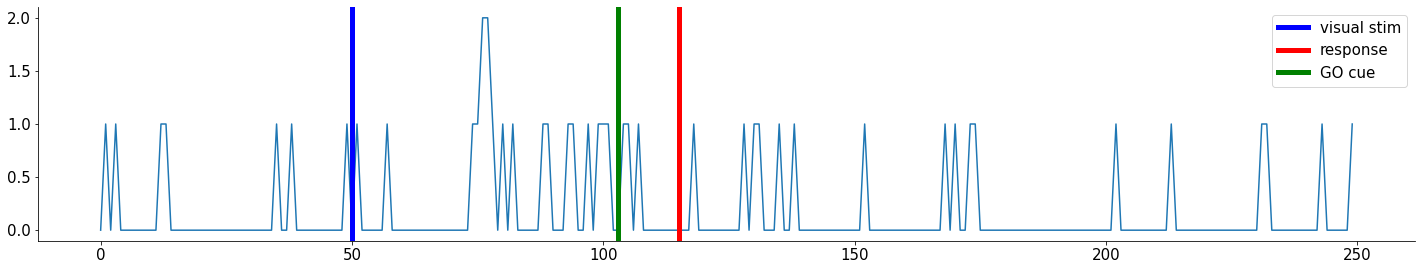

In [69]:
# function to loop through trial data and create 2 x 1 array describing the time
# point at which visual stimulus was displayed and a second event within the 
# trial (e.g. response, go cue onset). Option to keep units in seconds or change
# to 10ms time bin format used by spike data

def time_window_generator(start_window_variable, end_window_variable, spike_rate_format=True):
  '''
  Creates a time window on visual stim onset to later trial event

  Args:
    start_window_variable (float)               : fixed value for visual stim onset (s)
    end_window_variable (numpy array of floats) : array of second event times per trial (s)
    spike_rate_format (boolean)                 : boolean whether to calculate in 10ms bins
  
  Returns:
    numpy array of floats

  '''
  number_trials = len(end_window_variable) #loop through number of trials per session
  start_window = start_window_variable
  time_window = np.zeros((number_trials, 2)) #initialize time_window variable
  
  
  for trial in range(number_trials):
    time_window[trial] = np.array([start_window, end_window_variable[trial]]) * 100
    
  if spike_rate_format:
    time_window = np.round(time_window)


  return time_window

for session in range(len(alldat)):
  
  dat = alldat[session]
  dat['stim_response_time_window'] = time_window_generator(dat['stim_onset'], dat['response_time'])
  dat['stim_gocue_time_window'] = time_window_generator(dat['stim_onset'], dat['gocue'])
  

# example plot of time windows on single trial
plt.plot(alldat[0]['spks'][670][0])
plt.axvline(alldat[0]['stim_response_time_window'][0][0], color='blue', linewidth=5, label = 'visual stim')
plt.axvline(alldat[0]['stim_response_time_window'][0][1], color='red', linewidth=5, label='response')
plt.axvline(alldat[0]['stim_gocue_time_window'][0][1], color='green', linewidth=5, label='GO cue')
plt.legend()








# Accuracy Analysis (Phil)

Defining a function to compute accuracy analysis



In [ ]:

#Load a debugger
from IPython.core.debugger import set_trace

import numpy as np

# Loading steinmetz data so that we don't have to download it every time.
fname = ["steinmetz_part1.npz", "steinmetz_part2.npz", "steinmetz_part3.npz"]
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

def compute_accuracy(data = alldat, session = list(np.arange(0, 39, 1))):
    """ 
    arguments:
    session: a list of session numbers to evaluate.  Default is all session in dat.
    
    output:
    accuracy: a session-length np.array of n-trial length arrays listing correct = 1, incorrect = 0
    accuracy_pct: a percentage score of correct vs. incorrect trials
    accuracy_move: a session-length np.array of arrays where movement was required
    accuracy_pct_move: a percentage score of correct vs. incorrect trials when movement was required
    indMove: index of trials where movement was supposed to happen within session
    """
    accuracy_all = []
    accuracy_move_all = []
    accuracy_bool_all = []
    accuracy_bool_move_all = []
    indMove_all = []
    
    for i, run in enumerate(session):
        # get relevant data
        
        #set_trace()
        response = data[i]['response'] # right - nogo - left (-1, 0, 1)
        vis_right = data[i]['contrast_right'] # 0 - low - high
        vis_left = data[i]['contrast_left'] # 0 - low - high

        #initialize empty boolean accuracy object
        accuracy_bool = np.zeros(len(response))

        # the following are the correct responses:
        # if vis_left > vis_right : response >0
        # if vis_left < vis_right : response <0
        # if vis_left = vis_right : response =0
        # trials below red line are incorrect
        is_correct = np.sign(response)==np.sign(vis_left-vis_right)
        accuracy_bool[is_correct] = 1
        accuracy = np.sum(accuracy_bool)/len(accuracy_bool)

        # Compute accuracy for only movement trials
        indMove = np.logical_or(vis_right > vis_left, vis_left > vis_right)

        # create vectors only of movement trials
        response_move = response[indMove]
        vis_right_move = vis_right[indMove]
        vis_left_move = vis_left[indMove]

        # compute accuracy only for movement trials
        accuracy_bool_move = np.zeros(len(response_move))

        is_correct_move = np.sign(response_move)==np.sign(vis_left_move - vis_right_move)
        accuracy_bool_move[is_correct_move] = 1
        accuracy_move = np.sum(accuracy_bool_move)/len(accuracy_bool_move)

        #set_trace()
        accuracy_all.append(accuracy)
        accuracy_move_all.append(accuracy_move)
        accuracy_bool_all.append(accuracy_bool)
        accuracy_bool_move_all.append(accuracy_bool_move)
        indMove_all.append(indMove)
        
    return([accuracy_all, accuracy_move_all, accuracy_bool_all, accuracy_bool_move_all, indMove])

accuracy_all, accuracy_move_all, accuracy_bool_all, accuracy_bool_move_all, indMove = compute_accuracy()

### Accuracy Plots

Accuracy for each session

import pandas as pd
import matplotlib.pyplot as plt

accuracy_data = pd.DataFrame({"Session": np.arange(0,39,1), "Accuracy": accuracy_all}, columns = ["Session", "Accuracy"])

ordered_accuracy_data = accuracy_data.sort_values("Accuracy", ignore_index = True)
ordered_accuracy_data["xmin"] = 0
ordered_accuracy_data["xmax"] = 0

for i in range(0, len(ordered_accuracy_data)):
    #set_trace()
    if ordered_accuracy_data.loc[i, "Accuracy"] <= 0.50:
        ordered_accuracy_data.loc[i, "xmin"] = ordered_accuracy_data.loc[i, "Accuracy"]
        ordered_accuracy_data.loc[i, "xmax"] = 0.50
    else:
        ordered_accuracy_data.loc[i, "xmin"] = 0.50
        ordered_accuracy_data.loc[i, "xmax"] = ordered_accuracy_data.loc[i, "Accuracy"]

#print(ordered_accuracy_data)

plt.figure(figsize=(12, 9), dpi=80)

plt.hlines(y = range(0,len(ordered_accuracy_data)), xmin = ordered_accuracy_data["xmin"], \
                     xmax = ordered_accuracy_data['Accuracy'], color = "blue", alpha= 0.4)
plt.scatter(ordered_accuracy_data["Accuracy"], range(0,len(ordered_accuracy_data)), \
                                                     color = "blue", s = 20, alpha=1)
plt.vlines(x = 0.5, ymin = 0, ymax = len(ordered_accuracy_data), color = "black")
#set_trace()
for i, label in enumerate(ordered_accuracy_data["Session"]):
    #set_trace()
    plt.annotate(label, (ordered_accuracy_data.loc[i, "Accuracy"], i))
 
# Add title and axis names
plt.title("Accuracy of all trials in each session", loc='left')
plt.xlabel('Accuracy')
plt.ylabel('Session (ordered)')
plt.xlim((0,1))
plt.grid(1, alpha = 0.5)

# show the graph
plt.show()

#set_trace()
